# Bayesian data analysis
___

**Gregory Farage, Śaunak Sen**    

    gfarage@uthsc.edu / sen@uthsc.edu
    Division of Biostatistics
    Department of Preventive Medicine
    University of Tennessee Health Science Center
    Memphis, TN


The Julia language is well-suited for Bayesian data analysis because it is possible to build upon probabilistic abtractions.  The [Turing.jl](https://turinglang.org/stable/) package provides Bayesian data analysis capabilities. It uses the domain-specific language in the `@model` macro to specify the joint distribution of observed and unobserved variables.  It is an example of a (Probabilistic Programming Language (PPL).  Other examples include [Stan](https://mc-stan.org/) and [MyMC](https://www.pymc.io/welcome.html).

### Outline of this notebook

- Normal one sample mean
- Bivariate normal with missing 
- Two-level Poisson regression
- Additional reading 

## Normal one sample mean

Consider the problem of estimating the mean of a normally distributed variable with an unknown mean and unit variance.

In [1]:
# load packages we will use
using Turing, Random, Plots, StatsPlots, LinearAlgebra, CSV, DataFrames

The `@model` macro specifies the joint distribution by specifying the conditional
distributions.

In [2]:
@model normalvar(y) = 
    begin
    # prior for mean
    μ ~ Normal(1.0,1/10)
    # likelihood
    y ~ MvNormal(fill(μ,length(y)),I)
    # alternative specification for iid distributions
    # y ~ filldist(Normal(μ,1.0),length(y))
end

normalvar (generic function with 2 methods)

We generate 100 observations from a normal distribution with mean 2 and variance 1.

In [3]:
Random.seed!(123);
normData = rand(Normal(2.0,1.0),100);

We create an object from which we can draw samples (because the joint distribution has been specified).

In [4]:
normModel = normalvar(normData);
# typeof(normModel) |> supertype |> supertype

Now we can draw samples from this joint distribution using the NUTS sampler.

In [5]:
normChain = sample(normModel,NUTS(),10_000);

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


In [6]:
normSummaries, normQuantiles = describe(normChain)

2-element Vector{ChainDataFrame}:
 Summary Statistics (1 x 8)
 Quantiles (1 x 6)

We can see from the summaries that the posterior distribution is a compromose between the prior and the data.  It is halfway between the prior (mean 1, sd 0.1), and the data (100 samples with mean 2 and variance 1). This is the expectation from theory.

In [7]:
normSummaries

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           μ    1.4759    0.0709     0.0007    0.0010   4320.2660    1.0000    ⋯
                                                                1 column omitted


In [8]:
normQuantiles

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           μ    1.3360    1.4292    1.4760    1.5227    1.6157


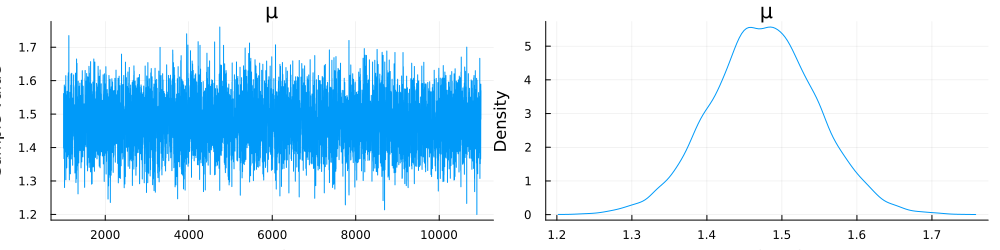

In [9]:
plot(normChain)

## Bivariate normal with missing data

The answer to the previous exercise was known.  Let us consider a non-trivial example -- that of a bivariate normal with some missing data.  We first write down the joint distribution of the observed and unobserved data.

In [10]:
@model bvNormalMissing(y) = 
    begin
    
    ## priors ##
    # weakly informative proper prior
    μ ~ MvNormal(zeros(2),1000.0*Matrix(I,2,2))
    # flat over plausible range
    ρ ~ Uniform(-0.99,0.99)
    s1 ~ Uniform(0.001,1000.0)
    s2 ~ Uniform(0.001,1000.0)
    
    ## likelihood ## 
    # sample size
    n = size(y,2)
    
    for i in 1:n
        # if the first observation is missing then the likelihood is
        # univariate normal for the second observation
        if(isnan(y[1,i]))
            # Turing.@addlogprob! logpdf(Normal(μ[2],1.0),y[2,i])
            y[2,i] ~ Normal(μ[2],s2)
        # if the second observation is missing then the likelihood is
        # univariate normal for the first observation
        elseif(isnan(y[2,i]))
            y[1,i] ~ Normal(μ[1],s1)
            # Turing.@addlogprob! logpdf(Normal(μ[1],1.0),y[1,i])
        # if both are observed we have bivariate normal likielihood
        else
            y[:,i] ~ MvNormal(μ,[s1^2 ρ*s1*s2; ρ*s1*s2 s2^2])
        end
    end
end

bvNormalMissing (generic function with 2 methods)

We simulate data from a bivariate normal with mean 2.0 for both variables
and variance is 1.0.  They have correlation 0.5.

In [11]:
# correlation matrix
R = [1 0.5; 0.5 1]
# simulate data
bvnData = rand(MvNormal(ones(2)*2,R),1000);
# first 200 are missing first obs
bvnData[1,1:200] .= NaN
# 501-700 are missing second obs
bvnData[2,501:700] .= NaN
# create the model
bvnModel = bvNormalMissing(bvnData);

In [12]:
bvnChain = sample(bvnModel,NUTS(),1000);
bvnSummaries, bnvQuantiles = describe(bvnChain)
bvnSummaries

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:09


Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

        μ[1]    1.9766    0.0332     0.0010    0.0011    911.8547    1.0003    ⋯
        μ[2]    1.9534    0.0345     0.0011    0.0012    959.0212    0.9991    ⋯
           ρ    0.5181    0.0281     0.0009    0.0009    901.2480    0.9993    ⋯
          s1    0.9806    0.0237     0.0007    0.0009    782.3319    0.9995    ⋯
          s2    1.0280    0.0256     0.0008    0.0008   1113.1180    0.9991    ⋯
                                                                1 column omitted


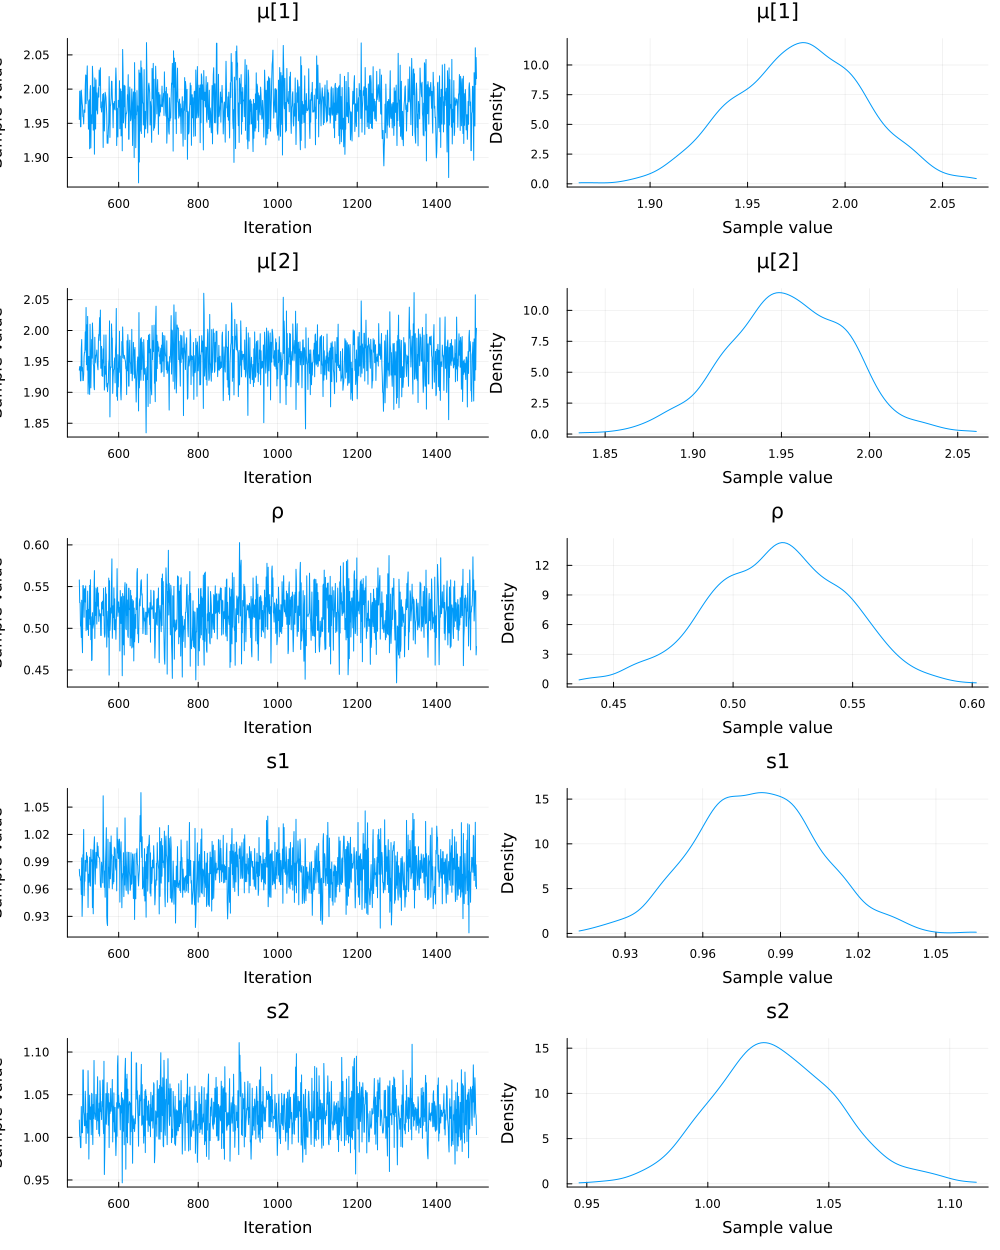

In [13]:
plot(bvnChain)

## Two-level Poisson regression

We will use the EPL data for this example.  We want to estimate the scoring ability of each team when playing at home.  We use a simplified model where we are observing the number of goals scored by each team at home.  We will use a two-level model.  First, we read in the data and just keep the relevant columns.

In [14]:
eplURL = "https://raw.githubusercontent.com/sens/smalldata/master/soccer/E0.csv"
epl = CSV.read(download(eplURL),DataFrame);
select!(epl,r"Date|Team|HT|FT") |> (x->first(x,5))

Row,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR
,String15,String15,String15,Int64,Int64,String1,Int64,Int64,String1
1,08/08/15,Bournemouth,Aston Villa,0,1,A,0,0,D
2,08/08/15,Chelsea,Swansea,2,2,D,2,1,H
3,08/08/15,Everton,Watford,2,2,D,0,1,A
4,08/08/15,Leicester,Sunderland,4,2,H,3,0,H
5,08/08/15,Man United,Tottenham,1,0,H,1,0,H


Our model assumes that each team has a propensity to score goals at home.  That propensity is different for each team and has a normal distribution with mean $\mu$ and standard deviation $\tau$ truncated to be positive.  We put hyperpriors on both of them.  For the former it is a weakly informative normal prior with mean equal to the average number of home goals scored across teams.  For the latter, we he a half-Cauchy distribution.  Given the scoring propensity, the data have a Poisson distribution.

In [15]:
@model function poissonGoals(goals,team)

    ## number of teams
    nteams = length(unique(team))
    teamnames = sort(unique(team))
    
    ## priors
    μ ~ Normal(mean(goals),4*std(goals))
    τ ~ truncated(Cauchy(0,2);lower=0)

    ## team-level effects (scoring propensity)
    teamPropensity ~ filldist(truncated(Normal(μ,τ);lower=0),nteams)
    teamPropensityDict = mapreduce((x,y) -> Dict([(x,y)]), merge,
        teamnames,teamPropensity)

    ## likelihood
    expectedgoals = (x->teamPropensityDict[x]).(team)
    return goals .~ Poisson.(expectedgoals)
end;

We get the data, and then sample from the posterior distribution.

In [16]:
# get the data
goals = epl.FTHG;
team = epl.HomeTeam;

In [17]:
poisModel = poissonGoals(goals,team);

In [18]:
poisChain = sample(poisModel,NUTS(),10_000);

┌ Info: Found initial step size
└   ϵ = 0.4
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:44


In [19]:
poisSummaries, poisQuantiles = describe(poisChain);

Now let's look at the posterior summaries of the propensities and compare it with the raw mean number of goals.

In [20]:
df = DataFrame(poisSummaries);
df.parameters[3:end] = Symbol.(sort(unique(team)));
df;

In [21]:
dfRaw = combine( groupby(epl,:HomeTeam), :FTHG => mean => :meanHomeGoals ) |> sort;

In [22]:
hcat(df[3:end,1:3],dfRaw)

Row,parameters,mean,std,HomeTeam,meanHomeGoals
,Symbol,Float64,Float64,String15,Float64
1,Arsenal,1.59154,0.216259,Arsenal,1.63158
2,Aston Villa,1.01337,0.226248,Aston Villa,0.736842
3,Bournemouth,1.34235,0.210039,Bournemouth,1.21053
4,Chelsea,1.61926,0.22607,Chelsea,1.68421
5,Crystal Palace,1.20221,0.214031,Crystal Palace,1.0
6,Everton,1.7045,0.232144,Everton,1.84211
7,Leicester,1.70616,0.22841,Leicester,1.84211
8,Liverpool,1.64676,0.223748,Liverpool,1.73684
9,Man City,2.01871,0.265717,Man City,2.47368


Notice the shrinkage for the estimtes for teams with more extreme scoring records (eg. Crystal Palace and Man City).

## Additional reading

The Turing.jl website has some excellent [tutorials](https://turinglang.org/v0.24/tutorials/) including one for [Bayesian neural nets](https://turinglang.org/v0.24/tutorials/03-bayesian-neural-network/) using Flux.jl. Jose Storopoli has some excellent material on [Bayesian computation](https://storopoli.github.io/Bayesian-Julia/) using Turing.jl with detailed explanations. And finaly, there is the excellent book on [Bayesian Data Analysis](https://users.aalto.fi/~ave/BDA3.pdf) by Gelman, Carlin, Dunson, Stern, Vehtari and Rubin.